In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

## Part 3

#### dataset: `Compact.csv`

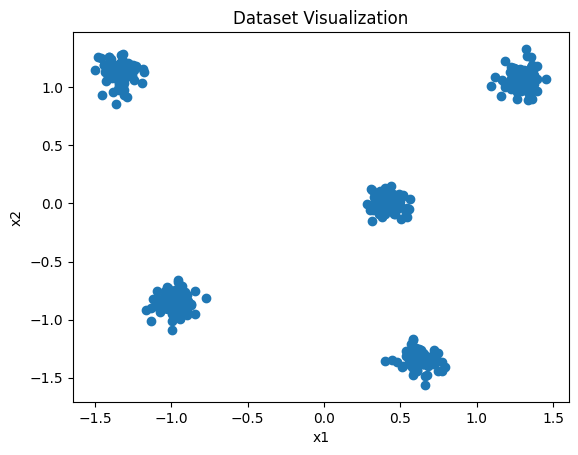

In [15]:
data = pd.read_csv('Dataset_a5/Dataset2/Compact.csv')

X = data[["x1", "x2"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Visualization")
plt.show()


In [16]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans.fit(X_scaled)
labels_kmeans = kmeans.labels_

# print(f"Silhouette Score for KMeans: {silhouette_score(X_scaled, labels_kmeans)}")

In [17]:
linkages = ['ward', 'complete', 'average', 'single']

best_silhouette = -1
best_linkage = None

for linkage in linkages:
    agg_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg_clustering.fit(X_scaled)
    labels_agg_tmp = agg_clustering.labels_

    silhouette_tmp = silhouette_score(X_scaled, labels_agg_tmp)

    if silhouette_tmp > best_silhouette:
        best_silhouette = silhouette_tmp
        best_linkage = linkage

print(f"Best linkage: {best_linkage}")
# print(f"Best silhouette score: {best_silhouette}")

agg_clustering = AgglomerativeClustering(n_clusters=5, linkage=best_linkage)
agg_clustering.fit(X_scaled)
labels_agg = agg_clustering.labels_

Best linkage: ward


In [18]:
eps_values = [1, 2, 3, 4, 5]  # Range of eps values to try
min_samples_values = [1, 10, 20, 30, 40, 50]  # Range of min_samples values to try

best_silhouette = -1
best_eps = None
best_min_samples = None
labels_dbscan = None
noise_points = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_scaled)
        labels_dbscan_tmp = dbscan.labels_

        # Ignore noise points for silhouette score
        non_noise_indices = labels_dbscan_tmp != -1
        if len(set(labels_dbscan_tmp[non_noise_indices])) > 1:
            silhouette_tmp = silhouette_score(X_scaled[non_noise_indices], labels_dbscan_tmp[non_noise_indices])
        else:
            silhouette_tmp = -1  # Assign a low silhouette score if only one cluster is found

        if silhouette_tmp > best_silhouette:
            best_silhouette = silhouette_tmp
            best_eps = eps
            best_min_samples = min_samples
            labels_dbscan = labels_dbscan_tmp
            noise_points = np.sum(labels_dbscan == -1)

# Use best parameters for DBSCAN
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(X_scaled)
labels_dbscan = dbscan.labels_
noise_points = np.sum(labels_dbscan == -1)

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
# print(f"Best silhouette score: {best_silhouette}")

Best eps: 1
Best min_samples: 1


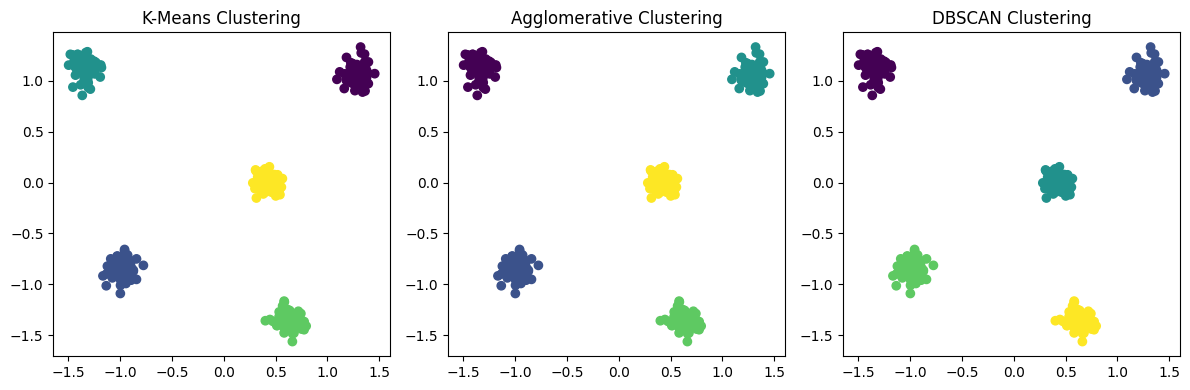

In [19]:
plt.figure(figsize=(12, 4))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_kmeans)
plt.title("K-Means Clustering")

# Agglomerative Clustering
plt.subplot(1, 3, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_agg)
plt.title("Agglomerative Clustering")

# DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dbscan)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

In [20]:
# Silhouette scores
silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans)
silhouette_agg = silhouette_score(X_scaled, labels_agg)
silhouette_dbscan = silhouette_score(X_scaled[non_noise_indices], labels_dbscan[non_noise_indices])

# Intra-cluster distance (sum of squared distances to centroids)
kmeans_intra_distance = kmeans.inertia_
agg_intra_distance = np.sum([np.linalg.norm(X_scaled[labels_agg == i] - np.mean(X_scaled[labels_agg == i], axis=0)) ** 2 for i in range(3)])
dbscan_intra_distance = np.sum([np.linalg.norm(X_scaled[labels_dbscan == i] - np.mean(X_scaled[labels_dbscan == i], axis=0)) ** 2 for i in range(np.max(labels_dbscan) + 1)])

# Tabulate results
results = pd.DataFrame({
    "Algorithm": ["K-Means", "Agglomerative Clustering", "DBSCAN"],
    "Silhouette Score": [silhouette_kmeans, silhouette_agg, silhouette_dbscan],
    "Intra-Cluster Distance": [kmeans_intra_distance, agg_intra_distance, dbscan_intra_distance],
    "Noise Points": [0, 0, noise_points]
})

results

,Algorithm,Silhouette Score,Intra-Cluster Distance,Noise Points
0,K-Means,0.913317,4.351241,0
1,Agglomerative Clustering,0.913317,2.875042,0
2,DBSCAN,0.913317,4.351241,0


Analysis:

It appears that Agglomerative clustering is the best method for this dataset. While the silhouette score is same for all the methods, if we see intra-cluster distance, Agglomerative clustering has the lowest value. This means that the clusters are more compact and well separated. 

#### dataset: `Skewed.csv`

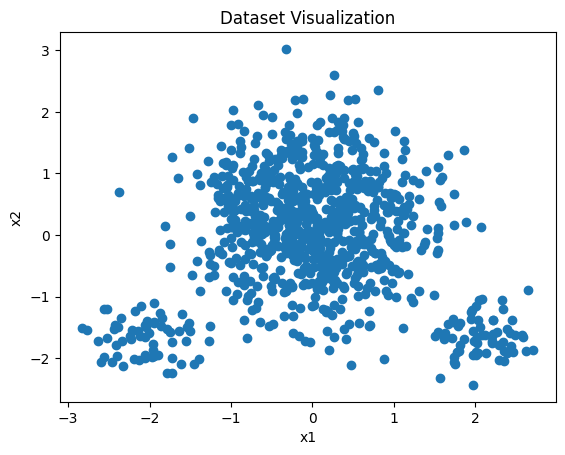

In [23]:
data = pd.read_csv('Dataset_a5/Dataset2/Skewed.csv')

X = data[["x1", "x2"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Visualization")
plt.show()


In [24]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans.fit(X_scaled)
labels_kmeans = kmeans.labels_

In [26]:
linkages = ['ward', 'complete', 'average', 'single']

best_silhouette = -1
best_linkage = None

for linkage in linkages:
    agg_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg_clustering.fit(X_scaled)
    labels_agg_tmp = agg_clustering.labels_

    silhouette_tmp = silhouette_score(X_scaled, labels_agg_tmp)

    if silhouette_tmp > best_silhouette:
        best_silhouette = silhouette_tmp
        best_linkage = linkage

print(f"Best linkage: {best_linkage}")
# print(f"Best silhouette score: {best_silhouette}")

agg_clustering = AgglomerativeClustering(n_clusters=5, linkage=best_linkage)
agg_clustering.fit(X_scaled)
labels_agg = agg_clustering.labels_

Best linkage: ward


In [29]:
eps_values = [1, 2, 3, 4, 5]  # Range of eps values to try
min_samples_values = [1, 10, 20, 30, 40, 50]  # Range of min_samples values to try

best_silhouette = -1
best_eps = None
best_min_samples = None
labels_dbscan = None
noise_points = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_scaled)
        labels_dbscan_tmp = dbscan.labels_

        # Ignore noise points for silhouette score
        non_noise_indices = labels_dbscan_tmp != -1
        if len(set(labels_dbscan_tmp[non_noise_indices])) > 1:
            silhouette_tmp = silhouette_score(X_scaled[non_noise_indices], labels_dbscan_tmp[non_noise_indices])
        else:
            silhouette_tmp = -1  # Assign a low silhouette score if only one cluster is found

        if silhouette_tmp > best_silhouette:
            best_silhouette = silhouette_tmp
            best_eps = eps
            best_min_samples = min_samples
            labels_dbscan = labels_dbscan_tmp
            noise_points = np.sum(labels_dbscan == -1)

if best_eps is not None and best_min_samples is not None:
    print(f"Best eps: {best_eps}")
    print(f"Best min_samples: {best_min_samples}")
    # print(f"Best silhouette score: {best_silhouette}")

    # Use best parameters for DBSCAN
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan.fit(X_scaled)
    labels_dbscan = dbscan.labels_
    noise_points = np.sum(labels_dbscan == -1)
else:
    print("No valid eps and min_samples combination found.")

No valid eps and min_samples combination found.


tbd need to confirm

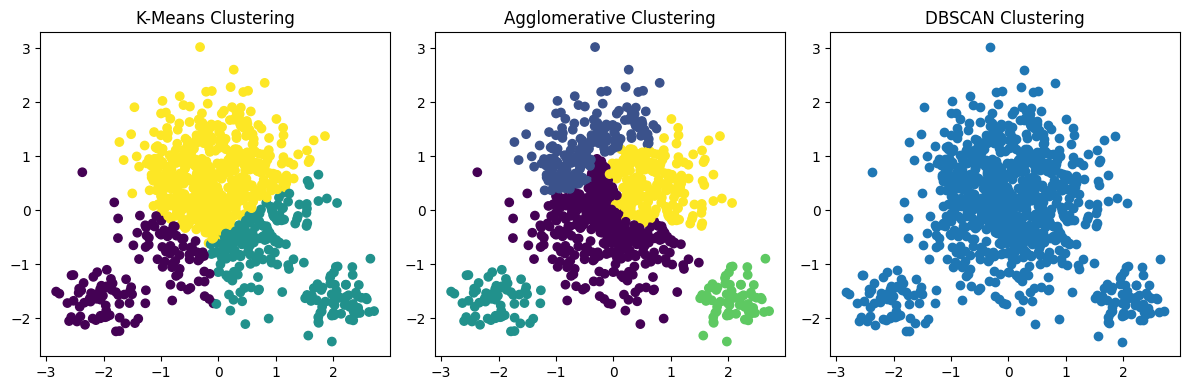

In [30]:
plt.figure(figsize=(12, 4))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_kmeans)
plt.title("K-Means Clustering")

# Agglomerative Clustering
plt.subplot(1, 3, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_agg)
plt.title("Agglomerative Clustering")

# DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dbscan)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

In [33]:
# Silhouette scores
silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans)
silhouette_agg = silhouette_score(X_scaled, labels_agg)
# silhouette_dbscan = silhouette_score(X_scaled[non_noise_indices], labels_dbscan[non_noise_indices])
silhouette_dbscan = 'NA'

# Intra-cluster distance (sum of squared distances to centroids)
kmeans_intra_distance = kmeans.inertia_
agg_intra_distance = np.sum([np.linalg.norm(X_scaled[labels_agg == i] - np.mean(X_scaled[labels_agg == i], axis=0)) ** 2 for i in range(3)])
# dbscan_intra_distance = np.sum([np.linalg.norm(X_scaled[labels_dbscan == i] - np.mean(X_scaled[labels_dbscan == i], axis=0)) ** 2 for i in range(np.max(labels_dbscan) + 1)])
dbscan_intra_distance = 'NA'

# Tabulate results
results = pd.DataFrame({
    "Algorithm": ["K-Means", "Agglomerative Clustering", "DBSCAN"],
    "Silhouette Score": [silhouette_kmeans, silhouette_agg, silhouette_dbscan],
    "Intra-Cluster Distance": [kmeans_intra_distance, agg_intra_distance, dbscan_intra_distance],
    "Noise Points": [0, 0, noise_points]
})

results

,Algorithm,Silhouette Score,Intra-Cluster Distance,Noise Points
0,K-Means,0.4093,761.862281,0.0
1,Agglomerative Clustering,0.335053,374.072443,0.0
2,DBSCAN,NA,NA,NaN


#### dataset: `Subclusters.csv`

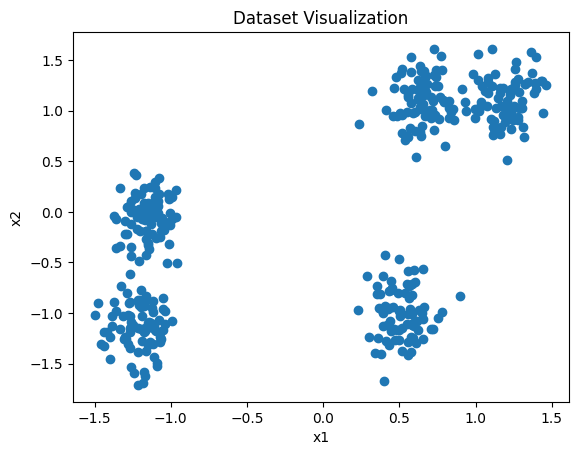

In [34]:
data = pd.read_csv('Dataset_a5/Dataset2/Subclusters.csv')

X = data[["x1", "x2"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Visualization")
plt.show()


In [35]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans.fit(X_scaled)
labels_kmeans = kmeans.labels_

In [36]:
linkages = ['ward', 'complete', 'average', 'single']

best_silhouette = -1
best_linkage = None

for linkage in linkages:
    agg_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg_clustering.fit(X_scaled)
    labels_agg_tmp = agg_clustering.labels_

    silhouette_tmp = silhouette_score(X_scaled, labels_agg_tmp)

    if silhouette_tmp > best_silhouette:
        best_silhouette = silhouette_tmp
        best_linkage = linkage

print(f"Best linkage: {best_linkage}")
# print(f"Best silhouette score: {best_silhouette}")

agg_clustering = AgglomerativeClustering(n_clusters=5, linkage=best_linkage)
agg_clustering.fit(X_scaled)
labels_agg = agg_clustering.labels_

Best linkage: ward


In [38]:
eps_values = [1, 2, 3, 4, 5]  # Range of eps values to try
min_samples_values = [1, 10, 20, 30, 40, 50]  # Range of min_samples values to try

best_silhouette = -1
best_eps = None
best_min_samples = None
labels_dbscan = None
noise_points = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_scaled)
        labels_dbscan_tmp = dbscan.labels_

        # Ignore noise points for silhouette score
        non_noise_indices = labels_dbscan_tmp != -1
        if len(set(labels_dbscan_tmp[non_noise_indices])) > 1:
            silhouette_tmp = silhouette_score(X_scaled[non_noise_indices], labels_dbscan_tmp[non_noise_indices])
        else:
            silhouette_tmp = -1  # Assign a low silhouette score if only one cluster is found

        if silhouette_tmp > best_silhouette:
            best_silhouette = silhouette_tmp
            best_eps = eps
            best_min_samples = min_samples
            labels_dbscan = labels_dbscan_tmp
            noise_points = np.sum(labels_dbscan == -1)

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
# print(f"Best silhouette score: {best_silhouette}")

# Use best parameters for DBSCAN
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(X_scaled)
labels_dbscan = dbscan.labels_
noise_points = np.sum(labels_dbscan == -1)

Best eps: 1
Best min_samples: 1


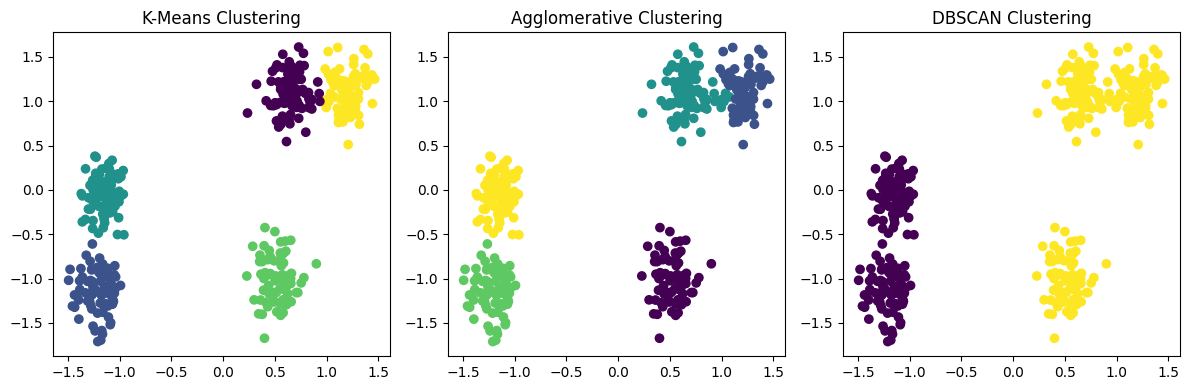

In [39]:
plt.figure(figsize=(12, 4))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_kmeans)
plt.title("K-Means Clustering")

# Agglomerative Clustering
plt.subplot(1, 3, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_agg)
plt.title("Agglomerative Clustering")

# DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dbscan)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

In [40]:
# Silhouette scores
silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans)
silhouette_agg = silhouette_score(X_scaled, labels_agg)
silhouette_dbscan = silhouette_score(X_scaled[non_noise_indices], labels_dbscan[non_noise_indices])

# Intra-cluster distance (sum of squared distances to centroids)
kmeans_intra_distance = kmeans.inertia_
agg_intra_distance = np.sum([np.linalg.norm(X_scaled[labels_agg == i] - np.mean(X_scaled[labels_agg == i], axis=0)) ** 2 for i in range(3)])
dbscan_intra_distance = np.sum([np.linalg.norm(X_scaled[labels_dbscan == i] - np.mean(X_scaled[labels_dbscan == i], axis=0)) ** 2 for i in range(np.max(labels_dbscan) + 1)])

# Tabulate results
results = pd.DataFrame({
    "Algorithm": ["K-Means", "Agglomerative Clustering", "DBSCAN"],
    "Silhouette Score": [silhouette_kmeans, silhouette_agg, silhouette_dbscan],
    "Intra-Cluster Distance": [kmeans_intra_distance, agg_intra_distance, dbscan_intra_distance],
    "Noise Points": [0, 0, noise_points]
})

results

,Algorithm,Silhouette Score,Intra-Cluster Distance,Noise Points
0,K-Means,0.647196,25.159198,0
1,Agglomerative Clustering,0.636009,16.284061,0
2,DBSCAN,0.563082,331.575769,0


Analysis:

K-Means and Agglomerative clustering both do a good job in clustering the data, while DBSCAN does not perform well, as it is not able to identify the subclusters. The silhouette score is highest for Agglomerative clustering, but the intra-cluster distance is lowest for K-Means. This means that K-Means is able to create more compact clusters.

#### dataset: `wellSeperated.csv`

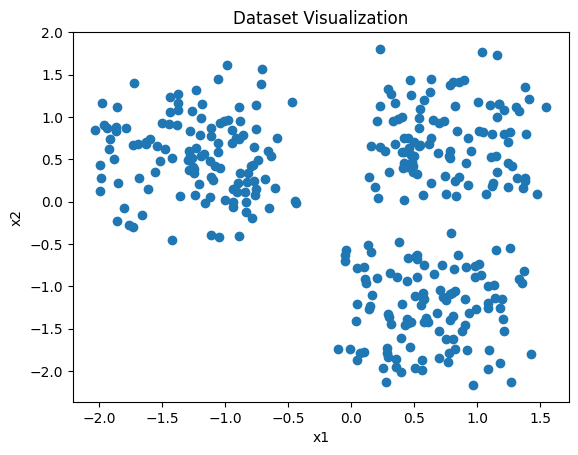

In [41]:
data = pd.read_csv('Dataset_a5/Dataset2/wellSeperated.csv')

X = data[["x1", "x2"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Visualization")
plt.show()


In [42]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans.fit(X_scaled)
labels_kmeans = kmeans.labels_

In [43]:
linkages = ['ward', 'complete', 'average', 'single']

best_silhouette = -1
best_linkage = None

for linkage in linkages:
    agg_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg_clustering.fit(X_scaled)
    labels_agg_tmp = agg_clustering.labels_

    silhouette_tmp = silhouette_score(X_scaled, labels_agg_tmp)

    if silhouette_tmp > best_silhouette:
        best_silhouette = silhouette_tmp
        best_linkage = linkage

print(f"Best linkage: {best_linkage}")
# print(f"Best silhouette score: {best_silhouette}")

agg_clustering = AgglomerativeClustering(n_clusters=5, linkage=best_linkage)
agg_clustering.fit(X_scaled)
labels_agg = agg_clustering.labels_

Best linkage: ward


In [46]:
eps_values = [1, 2, 3, 4, 5]  # Range of eps values to try
min_samples_values = [1, 10, 20, 30, 40, 50]  # Range of min_samples values to try

best_silhouette = -1
best_eps = None
best_min_samples = None
labels_dbscan = None
noise_points = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_scaled)
        labels_dbscan_tmp = dbscan.labels_

        # Ignore noise points for silhouette score
        non_noise_indices = labels_dbscan_tmp != -1
        if len(set(labels_dbscan_tmp[non_noise_indices])) > 1:
            silhouette_tmp = silhouette_score(X_scaled[non_noise_indices], labels_dbscan_tmp[non_noise_indices])
        else:
            silhouette_tmp = -1  # Assign a low silhouette score if only one cluster is found

        if silhouette_tmp > best_silhouette:
            best_silhouette = silhouette_tmp
            best_eps = eps
            best_min_samples = min_samples
            labels_dbscan = labels_dbscan_tmp
            noise_points = np.sum(labels_dbscan == -1)

if best_eps is not None and best_min_samples is not None:
    print(f"Best eps: {best_eps}")
    print(f"Best min_samples: {best_min_samples}")
    print(f"Best silhouette score: {best_silhouette}")

    # Use best parameters for DBSCAN
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan.fit(X_scaled)
    labels_dbscan = dbscan.labels_
    noise_points = np.sum(labels_dbscan == -1)
else:
    print("No valid eps and min_samples combination found.")

No valid eps and min_samples combination found.


PROBLEM

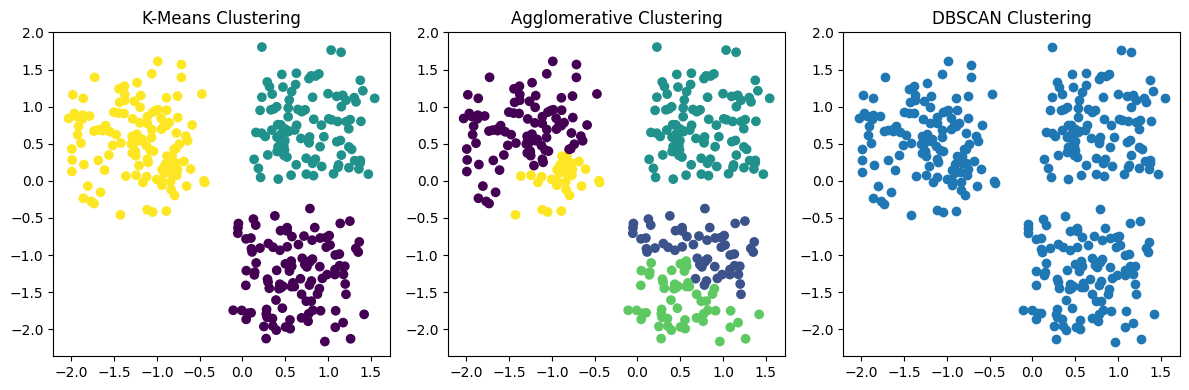

In [47]:
plt.figure(figsize=(12, 4))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_kmeans)
plt.title("K-Means Clustering")

# Agglomerative Clustering
plt.subplot(1, 3, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_agg)
plt.title("Agglomerative Clustering")

# DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dbscan)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

In [48]:
# Silhouette scores
silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans)
silhouette_agg = silhouette_score(X_scaled, labels_agg)
# silhouette_dbscan = silhouette_score(X_scaled[non_noise_indices], labels_dbscan[non_noise_indices])
silhouette_dbscan = 'NA'

# Intra-cluster distance (sum of squared distances to centroids)
kmeans_intra_distance = kmeans.inertia_
agg_intra_distance = np.sum([np.linalg.norm(X_scaled[labels_agg == i] - np.mean(X_scaled[labels_agg == i], axis=0)) ** 2 for i in range(3)])
# dbscan_intra_distance = np.sum([np.linalg.norm(X_scaled[labels_dbscan == i] - np.mean(X_scaled[labels_dbscan == i], axis=0)) ** 2 for i in range(np.max(labels_dbscan) + 1)])
dbcan_intra_distance = 'NA'

# Tabulate results
results = pd.DataFrame({
    "Algorithm": ["K-Means", "Agglomerative Clustering", "DBSCAN"],
    "Silhouette Score": [silhouette_kmeans, silhouette_agg, silhouette_dbscan],
    "Intra-Cluster Distance": [kmeans_intra_distance, agg_intra_distance, dbscan_intra_distance],
    "Noise Points": [0, 0, noise_points]
})

results

,Algorithm,Silhouette Score,Intra-Cluster Distance,Noise Points
0,K-Means,0.613735,118.361148,0.0
1,Agglomerative Clustering,0.384491,75.178227,0.0
2,DBSCAN,NA,331.575769,NaN
